# Setup

import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import warnings
import os
import pandas as pd
import anndata as ad
import seaborn as sns

In [2]:
sc.set_figure_params(figsize=(4,4),  dpi=150, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/notebook/Joe/M-cells/code/epithelial_signature_processing'

## file paths

### demeter

In [ ]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [ ]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

# Data import

Data from: https://www.nature.com/articles/nature24489 <br>
Accession link: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92332 <br>
Ex vivo data: GSE92332_Org_RANKL_UMIcounts.txt.gz <br>
In vivo data: GSE92332_atlas_UMIcounts.txt.gz <br>

## Whole Atlas

In [4]:
atlasUMI = pd.read_csv(f"{rawDataPath}epithelial_atlases/Intestine_epithelium_atlas/GSE92332_atlas_UMIcounts.txt", sep="\t").T
atlasAdata = ad.AnnData(atlasUMI)
atlasAdata.obs["cell_type"] = [i[1] for i in atlasAdata.obs.index.str.rsplit("_", 1)]
atlasAdata.obs["batch"] = [i[0] for i in atlasAdata.obs.index.str.split("_")]

In [5]:
atlasAdata

AnnData object with n_obs × n_vars = 7216 × 15971
    obs: 'cell_type', 'batch'

## M cell ex vivo culture

In [6]:
mCellUMI = pd.read_csv(f"{rawDataPath}epithelial_atlases/Intestine_epithelium_atlas/GSE92332_Org_RANKL_UMIcounts.txt", sep="\t").T
mAdata = ad.AnnData(mCellUMI)
mAdata.obs["cell_type"] = [i[1] for i in mAdata.obs.index.str.rsplit("_", 1)]
mAdata.obs["batch"] = [i[0] for i in mAdata.obs.index.str.split("_")]
mAdata.obs["treatment"] = [i[1] for i in mAdata.obs.index.str.rsplit("_", 2)]

In [7]:
mAdata

AnnData object with n_obs × n_vars = 5434 × 15180
    obs: 'cell_type', 'batch', 'treatment'

# Process data

In [8]:
# Helper method for plotting QC metrics for scrnaseq package
def qc_plot(adata, counts_thresh=30000, genes_thresh=5000, mt_thresh=10, show_thresh=True):
    sns.set_style("ticks")
    sns.set_context("paper")
    fig=plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    sns.histplot(
        x=adata.obs.pct_counts_mt,
        hue=adata.obs.batch,
    )
    if show_thresh:
        plt.axvline(
            x=mt_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )

    plt.subplot(1,3,2)
    sns.scatterplot(
        x=adata.obs.total_counts,
        y=adata.obs.n_genes_by_counts,
        s=2,
        hue=adata.obs.batch,
        linewidth=0,
    )
    if show_thresh:
        plt.axvline(
            x=counts_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )
        plt.axhline(
            y=genes_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    plt.subplot(1,3,3)
    cell_data = pd.DataFrame()
    for category in adata.obs.batch.unique():
        category_data = adata[adata.obs.batch == category].obs.copy()
        category_data["rank"] = category_data.total_counts.rank(method="first", ascending=False,)
        cell_data = pd.concat([cell_data, category_data])
    cell_data = cell_data.sort_values(by="rank")
    sns.lineplot(
        x=cell_data["rank"],
        y=cell_data.total_counts,
        hue=cell_data.batch,
        hue_order=adata.obs.batch.unique(),
    )
    if show_thresh:
        plt.axhline(
            y=counts_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    fig.tight_layout()
    plt.show()

## Full Atlas

In [9]:
atlasAdata.layers["counts"] = atlasAdata.X.copy()
atlasAdata.var['mt'] = atlasAdata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(atlasAdata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(atlasAdata, target_sum=1e4)
sc.pp.log1p(atlasAdata)
atlasAdata.raw = atlasAdata

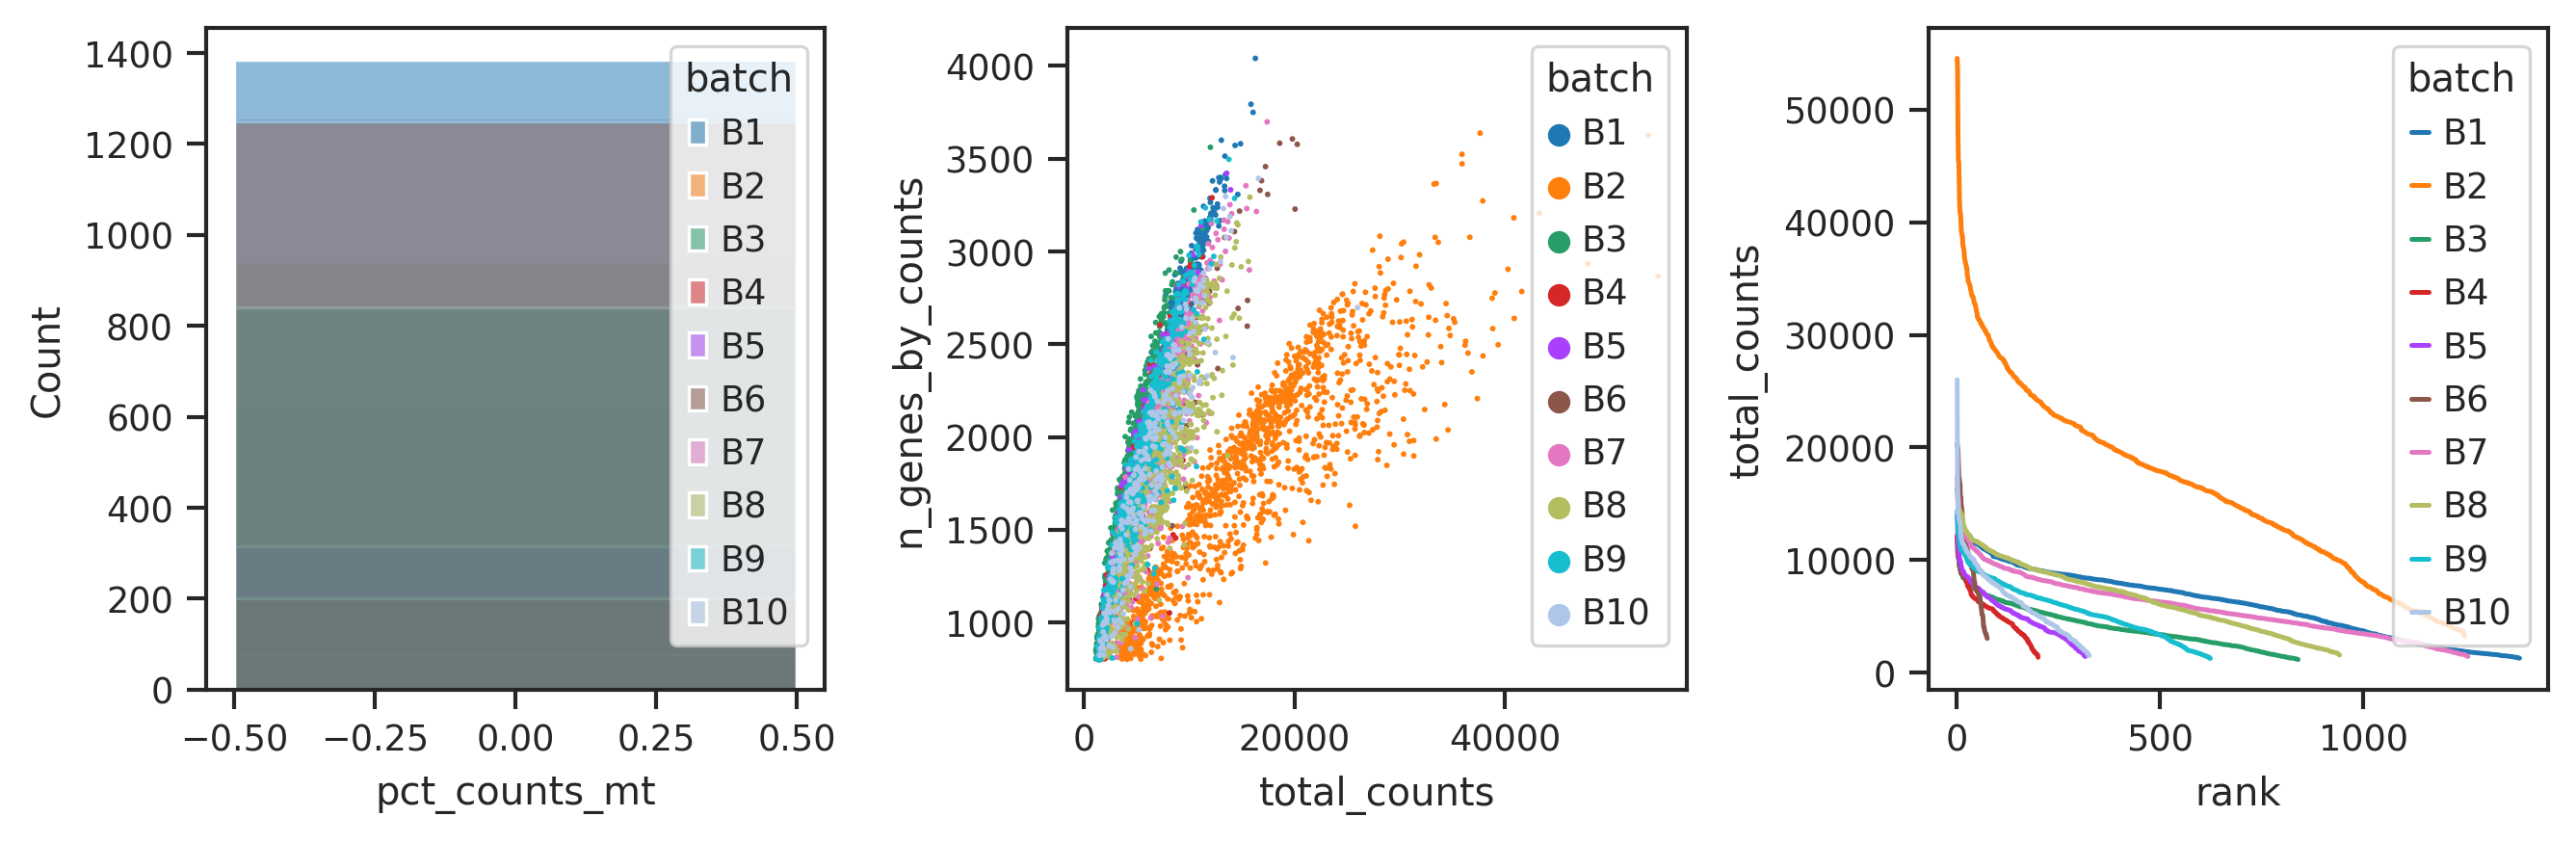

In [10]:
qc_plot(atlasAdata, show_thresh=False)

## M-cell data

In [11]:
mAdata.layers["counts"] = mAdata.X.copy()
mAdata.var['mt'] = mAdata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(mAdata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(mAdata, target_sum=1e4)
sc.pp.log1p(mAdata)
mAdata.raw = mAdata

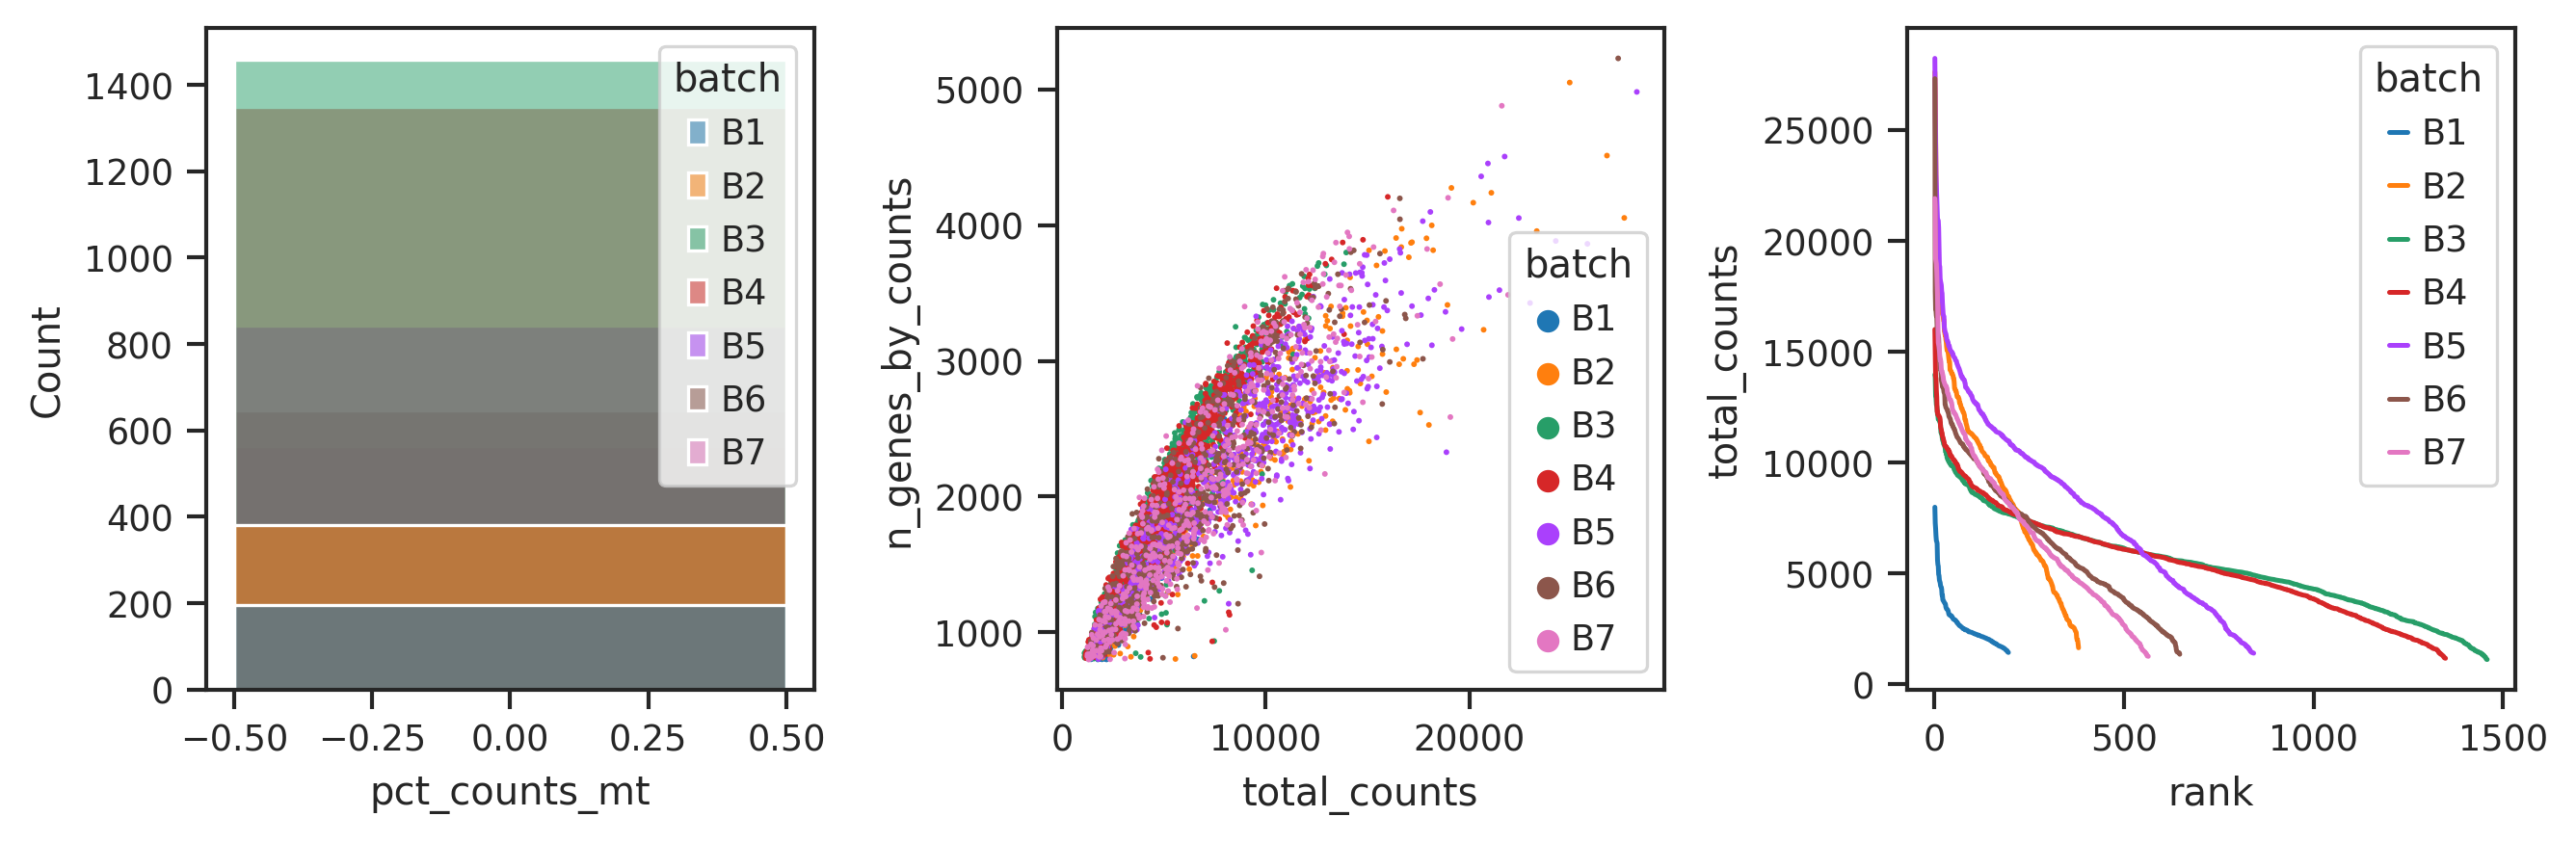

In [12]:
qc_plot(mAdata, show_thresh=False)

# Create pseudobulk signatures

In [13]:
def create_signature_matrix(adata, obs_key, save_path):
    signatures = pd.DataFrame(index=adata.var_names)
    for cell_type in adata.obs[obs_key].unique():
        signatures[cell_type] = adata[adata.obs[obs_key] == cell_type].X.mean(axis=0)
    signatures.to_csv(save_path)
    return signatures

## Full atlas

In [14]:
atlasSignatures = create_signature_matrix(atlasAdata, "cell_type", "../../analysis/cell_type_signatures/intestine_epithelium_signatures.csv")

In [15]:
atlasSignatures

,Enterocyte.Immature.Distal,Tuft,Goblet,Endocrine,Stem,TA.Early,Enterocyte.Mature.Proximal,TA.G1,TA.G2,Enterocyte.Progenitor.Early,Enterocyte.Progenitor.Late,Enterocyte.Immature.Proximal,Paneth,Enterocyte.Progenitor,Enterocyte.Mature.Distal
Mrpl15,1.140008,0.726606,0.670486,0.674128,0.754999,0.926375,0.769428,1.054853,0.988960,1.163573,1.094080,1.193603,0.780764,1.124344,0.844505
Lypla1,0.586315,0.463103,0.442135,0.342599,0.404570,0.388173,0.563007,0.396336,0.398325,0.438571,0.481159,0.582603,0.314218,0.361414,0.551686
Gm37988,0.000000,0.000000,0.001329,0.000000,0.000000,0.000000,0.000000,0.000000,0.005854,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tcea1,0.084600,0.100338,0.100280,0.132706,0.127716,0.133827,0.052806,0.108154,0.144368,0.111302,0.102563,0.090460,0.126162,0.120613,0.057521
Atp6v1h,0.182723,0.224821,0.133915,0.233317,0.130066,0.110972,0.120502,0.164903,0.129932,0.153611,0.156979,0.190981,0.120820,0.147035,0.147404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Prdx3,0.793743,0.817612,0.565054,0.863131,0.918346,0.813376,0.390984,0.832123,0.838274,0.839511,0.772139,0.820532,0.685328,0.723809,0.371094
Grk5,0.003887,0.019068,0.007329,0.065679,0.007624,0.011079,0.001155,0.014714,0.018560,0.007848,0.001584,0.000000,0.003997,0.003079,0.010336
Zfp950,0.180502,0.187040,0.175034,0.154474,0.199059,0.191182,0.118796,0.144192,0.211664,0.185447,0.253100,0.163719,0.144326,0.164010,0.173267
Gm7102,0.000000,0.000000,0.001504,0.000000,0.000361,0.001809,0.000000,0.001880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
atlasSignatures = atlasSignatures[["Tuft", "Goblet", "Endocrine", "Stem", "TA.G1", "TA.G2", "Paneth", "Enterocyte.Mature.Proximal", "Enterocyte.Mature.Distal"]]
atlasSignatures.columns = atlasSignatures.columns + "_intestine"
atlasSignatures

,Tuft_intestine,Goblet_intestine,Endocrine_intestine,Stem_intestine,TA.G1_intestine,TA.G2_intestine,Paneth_intestine,Enterocyte.Mature.Proximal_intestine,Enterocyte.Mature.Distal_intestine
Mrpl15,0.726606,0.670486,0.674128,0.754999,1.054853,0.988960,0.780764,0.769428,0.844505
Lypla1,0.463103,0.442135,0.342599,0.404570,0.396336,0.398325,0.314218,0.563007,0.551686
Gm37988,0.000000,0.001329,0.000000,0.000000,0.000000,0.005854,0.000000,0.000000,0.000000
Tcea1,0.100338,0.100280,0.132706,0.127716,0.108154,0.144368,0.126162,0.052806,0.057521
Atp6v1h,0.224821,0.133915,0.233317,0.130066,0.164903,0.129932,0.120820,0.120502,0.147404
...,...,...,...,...,...,...,...,...,...
Prdx3,0.817612,0.565054,0.863131,0.918346,0.832123,0.838274,0.685328,0.390984,0.371094
Grk5,0.019068,0.007329,0.065679,0.007624,0.014714,0.018560,0.003997,0.001155,0.010336
Zfp950,0.187040,0.175034,0.154474,0.199059,0.144192,0.211664,0.144326,0.118796,0.173267
Gm7102,0.000000,0.001504,0.000000,0.000361,0.001880,0.000000,0.000000,0.000000,0.000000


In [17]:
atlasSignatures.to_csv("../../analysis/cell_type_signatures/intestine_epithelium_signatures.csv")

## ex-vivo M cell data

In [18]:
exVivoSignatures = create_signature_matrix(mAdata, "cell_type", "../../analysis/cell_type_signatures/ex_vivo_intestine_epithelium_signatures.csv")

In [19]:
exVivoSignatures

,Enterocyte.Progenitor,Stem,Enterocyte.1,Enterocyte.Progenitor.Late,TA.Early,Goblet,Tuft,Enterocyte.2,Endocrine,TA,Mcell.Immature,M.cell,M.cell.Progenitor.1
Mrpl15,1.212010,1.329292,0.487971,0.774492,1.353633,0.855068,0.780132,0.905380,0.740005,1.461484,0.998047,0.782166,0.667779
Lypla1,0.932791,0.923969,0.512520,0.604078,0.852158,0.541030,0.791906,0.735641,0.520343,0.989134,0.794615,0.710449,0.600063
Gm37988,0.006987,0.000000,0.003345,0.000000,0.002858,0.000000,0.000000,0.000000,0.000000,0.001929,0.000000,0.002083,0.000000
Tcea1,0.073204,0.081947,0.071013,0.068445,0.080300,0.074320,0.104925,0.055315,0.106034,0.160594,0.074379,0.080041,0.040323
Rgs20,0.000000,0.000865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017240,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Prdx3,0.722131,0.924996,0.272407,0.439895,0.899277,0.600359,0.473205,0.603854,0.658121,1.363064,1.114500,0.782213,0.609857
Grk5,0.026831,0.016794,0.018496,0.011786,0.019573,0.010895,0.004591,0.016911,0.044557,0.008830,0.026457,0.014486,0.010572
Zfp950,0.124868,0.137644,0.106334,0.084963,0.111995,0.160521,0.243805,0.150736,0.151614,0.144816,0.222893,0.265043,0.135229
Gm7102,0.000000,0.001424,0.000000,0.000000,0.000000,0.000000,0.006856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
exVivoSignatures = exVivoSignatures[["M.cell", "Tuft", "Goblet", "Endocrine", "TA", "Enterocyte.1", "Enterocyte.2", "Stem"]]
exVivoSignatures.columns = exVivoSignatures.columns + "_intestine.ex.vivo"
exVivoSignatures

,M.cell_intestine.ex.vivo,Tuft_intestine.ex.vivo,Goblet_intestine.ex.vivo,Endocrine_intestine.ex.vivo,TA_intestine.ex.vivo,Enterocyte.1_intestine.ex.vivo,Enterocyte.2_intestine.ex.vivo,Stem_intestine.ex.vivo
Mrpl15,0.782166,0.780132,0.855068,0.740005,1.461484,0.487971,0.905380,1.329292
Lypla1,0.710449,0.791906,0.541030,0.520343,0.989134,0.512520,0.735641,0.923969
Gm37988,0.002083,0.000000,0.000000,0.000000,0.001929,0.003345,0.000000,0.000000
Tcea1,0.080041,0.104925,0.074320,0.106034,0.160594,0.071013,0.055315,0.081947
Rgs20,0.000000,0.000000,0.000000,0.017240,0.000000,0.000000,0.000000,0.000865
...,...,...,...,...,...,...,...,...
Prdx3,0.782213,0.473205,0.600359,0.658121,1.363064,0.272407,0.603854,0.924996
Grk5,0.014486,0.004591,0.010895,0.044557,0.008830,0.018496,0.016911,0.016794
Zfp950,0.265043,0.243805,0.160521,0.151614,0.144816,0.106334,0.150736,0.137644
Gm7102,0.000000,0.006856,0.000000,0.000000,0.000000,0.000000,0.000000,0.001424


In [21]:
exVivoSignatures.to_csv("../../analysis/cell_type_signatures/ex_vivo_intestine_epithelium_signatures.csv")